<a href="https://colab.research.google.com/github/kuzmatsukanov/kuzma_omri_noa_data_project/blob/noa/image_identification_noa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocessing import Pool
from functools import partial


from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

For multiprocessing later on:

In [2]:
def load_image(image_path, resize_shape=None):
    img = cv2.imread(image_path)
    if resize_shape is not None:
        img = cv2.resize(img, resize_shape)
    return img

def load_images_parallel(image_paths, n_jobs=4, resize_shape=None):
    with Pool(processes=n_jobs) as pool:
        func = partial(load_image, resize_shape=resize_shape)
        images = pool.map(func, image_paths)
    return np.array(images)

Mount the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

shared_folder_path = '/content/drive/MyDrive/ds_project_dataset'

!cp -r "$shared_folder_path" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataframe

In [3]:
df = pd.read_csv('ds_project_dataset/articles.csv')

In [4]:
df.sample(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
10641,542352007,542352,Cap Salomon Wool,69,Cap/peaked,Accessories,1010026,Other structure,9,Black,...,Accessories,F,Menswear,3,Menswear,25,Men Accessories,1019,Accessories,Flat cap in a woven wool blend. Cotton lining.
53331,703806003,703806,Sergio sandal,91,Sandals,Shoes,1010016,Solid,13,Beige,...,Flats,C,Ladies Accessories,1,Ladieswear,64,Womens Shoes,1020,Shoes,Sandals with narrow straps at the front and a ...
61748,734109019,734109,TP BEN fancy crewneck SB,252,Sweater,Garment Upper body,1010005,Colour blocking,22,Yellow,...,Kids Boy Jersey Basic,H,Children Sizes 92-140,4,Baby/Children,72,Boys Underwear & Basics,1002,Jersey Basic,Top in lightweight sweatshirt fabric with ribb...
43750,678016002,678016,Spec Occ Pearl Sweater,254,Top,Garment Upper body,1010002,Application/3D,51,Light Pink,...,Kids Girl Jersey Fancy,H,Children Sizes 92-140,4,Baby/Children,76,Kids Girl,1005,Jersey Fancy,"Top in sweatshirt fabric with sequins, dropped..."
95537,866929001,866929,SS DRESS solid,265,Dress,Garment Full body,1010016,Solid,51,Light Pink,...,Baby basics,G,Baby Sizes 50-98,4,Baby/Children,44,Baby Essentials & Complements,1002,Jersey Basic,"Short-sleeved dress in soft, organic cotton je..."


In [5]:
df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [6]:
df['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [7]:
df['perceived_colour_master_name'].unique()

array(['Black', 'White', 'Beige', 'Grey', 'Blue', 'Pink', 'Lilac Purple',
       'Red', 'Mole', 'Orange', 'Metal', 'Brown', 'Turquoise', 'Yellow',
       'Khaki green', 'Green', 'undefined', 'Unknown', 'Yellowish Green',
       'Bluish Green'], dtype=object)

In [8]:
df['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

Relevant categories

In [9]:
selected_categories = ['Garment Upper body', 'Underwear', 'Socks & Tights', 'Garment Lower body','Nightwear', 'Underwear/nightwear', 'Shoes', 'Swimwear', 'Garment Full body', 'Bags']
df = df[df['product_group_name'].isin(selected_categories)]

In [12]:
df.shape

(94165, 25)

In [13]:
df['subfolder'] = '0' + df['article_id'].astype(str).str[:2]
df['image_path'] = 'ds_project_dataset/images/' + df['subfolder'].str.strip() + '/0' + df['article_id'].astype(str) + '.jpg'

In [14]:
df['image_path']

0         ds_project_dataset/images/010/0108775015.jpg
1         ds_project_dataset/images/010/0108775044.jpg
2         ds_project_dataset/images/010/0108775051.jpg
3         ds_project_dataset/images/011/0110065001.jpg
4         ds_project_dataset/images/011/0110065002.jpg
                              ...                     
105536    ds_project_dataset/images/095/0952938001.jpg
105537    ds_project_dataset/images/095/0953450001.jpg
105538    ds_project_dataset/images/095/0953763001.jpg
105539    ds_project_dataset/images/095/0956217002.jpg
105541    ds_project_dataset/images/095/0959461001.jpg
Name: image_path, Length: 94165, dtype: object

In [15]:
df['image_path'][0]

'ds_project_dataset/images/010/0108775015.jpg'

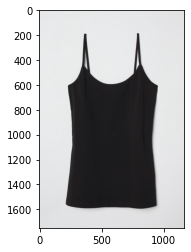

In [16]:
img = cv2.imread(df['image_path'][0])
plt.imshow(img)
plt.show()

For the training first trying to do the model on 10000 elements from the dataset as we have 90000 elements and it is already taking quite a long time.

In [18]:
valid_images = []
for index, row in tqdm(df[:10000].iterrows(), total=len(df[:10000])):
    if cv2.imread(row['image_path']) is not None:
        valid_images.append(row)

df_valid_images = pd.DataFrame(valid_images)

100%|██████████| 10000/10000 [07:34<00:00, 22.01it/s]


In [19]:
df_valid_images.shape

(9925, 27)

In [20]:
images = load_images_parallel(df_valid_images['image_path'].values, n_jobs=4, resize_shape=(80, 80))

Encoding for the model

In [21]:
new_df = pd.DataFrame(df_valid_images['article_id'])

In [22]:
new_df

,article_id
0,108775015
1,108775044
2,108775051
3,110065001
4,110065002
...,...
11224,546565005
11225,546565006
11226,546565007
11227,546565010


In [23]:
new_df = new_df.join(pd.get_dummies(df_valid_images['perceived_colour_master_name'], prefix='colour'))
new_df = new_df.join(pd.get_dummies(df_valid_images['product_group_name'], prefix='product'))
new_df = new_df.join(pd.get_dummies(df_valid_images['graphical_appearance_name'], prefix='pattern'))

In [24]:
new_df.sample(5)

,article_id,colour_Beige,colour_Black,colour_Blue,colour_Brown,colour_Green,colour_Grey,colour_Khaki green,colour_Lilac Purple,colour_Metal,...,pattern_Other pattern,pattern_Other structure,pattern_Placement print,pattern_Sequin,pattern_Slub,pattern_Solid,pattern_Stripe,pattern_Transparent,pattern_Treatment,pattern_Unknown
7427,513701012,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3692,463601013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11121,545720001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3015,445400014,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7908,518318003,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
color_array = new_df.filter(like='colour_').to_numpy()
pattern_array = new_df.filter(like='pattern_').to_numpy()
type_array = new_df.filter(like='product_').to_numpy()

In [26]:
color_array

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

Splitting + Model

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_color_train, y_color_val, y_type_train, y_type_val, y_pattern_train, y_pattern_val = train_test_split(
    images, color_array, type_array, pattern_array, test_size=0.2, random_state=42
)

In [28]:
inputs = Input(shape=(80, 80, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

color_output = Dense(len(df_valid_images['perceived_colour_master_name'].unique()), activation='softmax', name='color_output')(x)
type_output = Dense(len(df_valid_images['product_group_name'].unique()), activation='softmax', name='type_output')(x)
pattern_output = Dense(len(df_valid_images['graphical_appearance_name'].unique()), activation='softmax', name='pattern_output')(x)

model = Model(inputs=inputs, outputs=[color_output, type_output, pattern_output])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 78, 78, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 39, 39, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 37, 37, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [29]:
model.compile(
    optimizer='adam',
    loss={
        'color_output': 'categorical_crossentropy',
        'type_output': 'categorical_crossentropy',
        'pattern_output': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    X_train,
    {'color_output': y_color_train, 'type_output': y_type_train, 'pattern_output': y_pattern_train},
    validation_data=(
        X_val,
        {'color_output': y_color_val, 'type_output': y_type_val, 'pattern_output': y_pattern_val}
    ),
    epochs=20,
    batch_size=32
)

scores = model.evaluate(
    X_val,
    {'color_output': y_color_val, 'type_output': y_type_val, 'pattern_output': y_pattern_val}
)


Epoch 1/20
249/249 [==============================] - 10s 16ms/step - loss: 9.6938 - color_output_loss: 3.6392 - type_output_loss: 2.6195 - pattern_output_loss: 3.4350 - color_output_accuracy: 0.4194 - type_output_accuracy: 0.5839 - pattern_output_accuracy: 0.4684 - val_loss: 4.4421 - val_color_output_loss: 1.5166 - val_type_output_loss: 1.0614 - val_pattern_output_loss: 1.8641 - val_color_output_accuracy: 0.5365 - val_type_output_accuracy: 0.6610 - val_pattern_output_accuracy: 0.5139
Epoch 2/20
249/249 [==============================] - 3s 11ms/step - loss: 4.1257 - color_output_loss: 1.4480 - type_output_loss: 0.9457 - pattern_output_loss: 1.7319 - color_output_accuracy: 0.5568 - type_output_accuracy: 0.7013 - pattern_output_accuracy: 0.5293 - val_loss: 4.4356 - val_color_output_loss: 1.5872 - val_type_output_loss: 1.0147 - val_pattern_output_loss: 1.8338 - val_color_output_accuracy: 0.4836 - val_type_output_accuracy: 0.6917 - val_pattern_output_accuracy: 0.5048
Epoch 3/20
249/249 [=

In [31]:
print('Validation Accuracy - Color: {:.2f}%, Type: {:.2f}%, Pattern: {:.2f}%'.format(scores[4] * 100, scores[5] * 100, scores[6] * 100))


Validation Accuracy - Color: 57.68%, Type: 75.16%, Pattern: 54.91%


On new image

In [ ]:
# Load a new image
new_image_path = '/path/to/new/image.jpg'
new_image = cv2.imread(new_image_path)

# Resize the image to 224x224
new_image_resized = cv2.resize(new_image, (80, 80))

# Make a prediction on the new image
color_pred, type_pred, pattern_pred = model.predict(np.array([new_image_resized]))